# Brain Tumor Detector

## Definition of the Dataset

We decided to use the dataset : https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

It contains:
- 253 MRI images in total
- 98 No Tumor (38.74%)
- 155 Yes Tumor (61.26%)


## Installation and Import Packages

### Installation

In [165]:
%pip install numpy
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install opencv-python
%pip install torchvision
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing Packages 

In [166]:
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import cv2



## Reading MRI Images

This section reads and processes MRI images of brain scans. It’s divided into two parts: loading images with tumors and loading images without tumors.

In [167]:

# Load and process images from the dataset, return as numpy array
def load_and_process_images(path, size=(128, 128)):
    images = []
    for file in glob.iglob(path):
        img = cv2.imread(file)
        img = cv2.resize(img, size)
        # Convert from BGR to RGB for visualization consistency
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)


healthy_images = load_and_process_images('data/no/*.jpg')
infected_images = load_and_process_images('data/yes/*.jpg')


## Visualizing Brain MRI Images

The plot_images function is defined to visualize images from each category, "healthy" and "infected":

In [168]:
def plot_images(images, title):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Shape: {img.shape}')
    plt.show()

The images parameter receives a random list of images of each category.

<Figure size 1600x900 with 0 Axes>

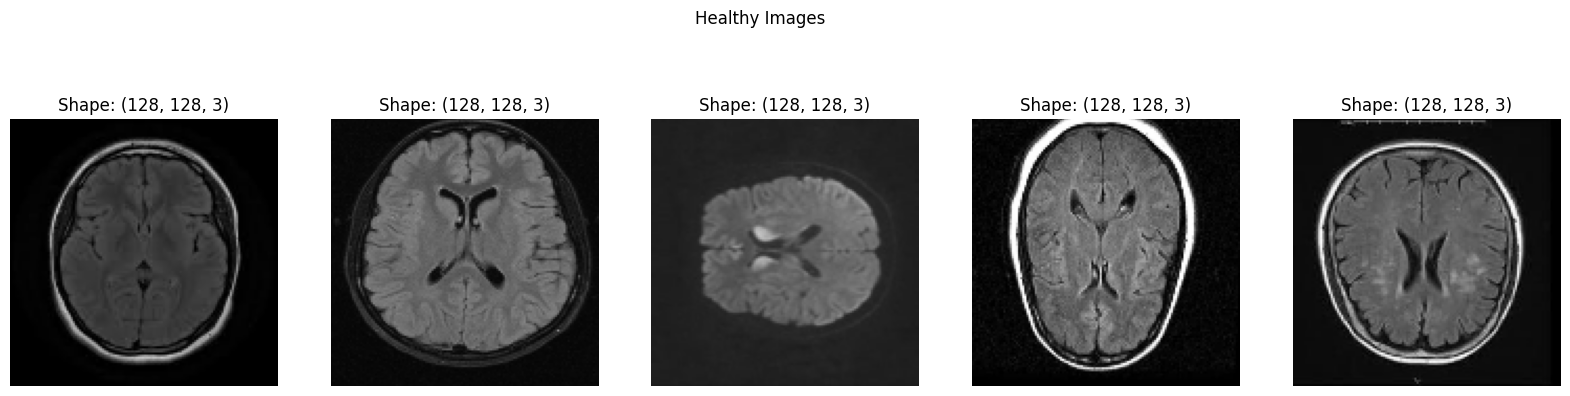

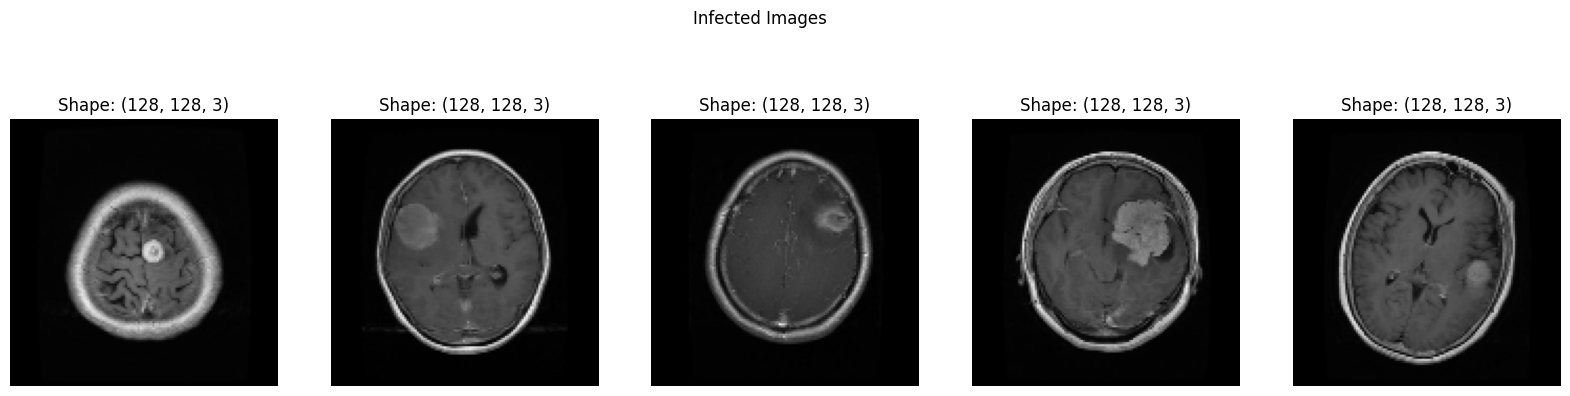

In [169]:
plt.figure(figsize=(16,9))

# Plot some healthy and infected images to visualize the data
plot_images(healthy_images[np.random.choice(healthy_images.shape[0], 5, replace=False)], 'Healthy Images')
plot_images(infected_images[np.random.choice(infected_images.shape[0], 5, replace=False)], 'Infected Images')

## Creating MRI custom dataset class

In [170]:
class MRIDataset(Dataset):
    def __init__(self, healthy_images, infected_images, transform=None):
        self.healthy_images = healthy_images
        self.infected_images = infected_images
        self.transform = transform
        self.labels = [0] * len(healthy_images) + [1] * len(infected_images)
        self.images = np.concatenate((healthy_images, infected_images), axis=0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
# Define any transformations if needed
transform = None

# Create the dataset
mri_dataset = MRIDataset(healthy_images, infected_images, transform=transform)

# Create a DataLoader for batching and shuffling
mri_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)

# Data Preprocessing

In [171]:
#Apply transformations for preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mri_dataset = MRIDataset(healthy_images, infected_images, transform=transform)

# Splitting the Dataset

In [172]:
# Split the dataset into train and test sets
data_size = len(mri_dataset)
train_size = int(0.8 * data_size) # 80% of the data is used for training
test_size = data_size - train_size # Remaining 20% is used for testing

train_dataset, test_dataset = random_split(mri_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transfer Learning with ResNet-18

In [173]:
# Use Transfer Learning with Pretrained Model
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        from torchvision.models import ResNet18_Weights
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.base_model(x)

# Freezing Base Model Layers

In [174]:
# Initialize model, loss function, and optimizer
model = TransferLearningModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.base_model.fc.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransferLearningModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

# Training the Model

In [175]:
# Training loop with Accuracy Tracking
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    train_accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        train_accuracies.append(accuracy)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")
    return train_accuracies


# Evaluating the Model

In [176]:
# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return acc, precision, recall, f1, cm


# Visualization

In [177]:
# Plotting Metrics
def plot_metrics(metrics, metric_names):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(metrics[0]) + 1), metrics[0], label=metric_names[0])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

def plot_bar_metrics(acc, precision, recall, f1):
    metric_values = [acc, precision, recall, f1]
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    plt.figure(figsize=(8, 6))
    sns.barplot(x=metric_labels, y=metric_values, palette='viridis')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1)
    for i, value in enumerate(metric_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.show()


In [178]:
# Train the model
train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs=50)
torch.save(model.state_dict(), 'model.pth')


Epoch [1/50], Loss: 0.4418, Accuracy: 0.8000
Epoch [2/50], Loss: 0.2819, Accuracy: 0.8828
Epoch [3/50], Loss: 0.2549, Accuracy: 0.9047
Epoch [4/50], Loss: 0.1853, Accuracy: 0.9281
Epoch [5/50], Loss: 0.1575, Accuracy: 0.9359
Epoch [6/50], Loss: 0.1401, Accuracy: 0.9406
Epoch [7/50], Loss: 0.1474, Accuracy: 0.9469
Epoch [8/50], Loss: 0.1170, Accuracy: 0.9578
Epoch [9/50], Loss: 0.1312, Accuracy: 0.9500
Epoch [10/50], Loss: 0.1172, Accuracy: 0.9594
Epoch [11/50], Loss: 0.0807, Accuracy: 0.9766
Epoch [12/50], Loss: 0.1358, Accuracy: 0.9547
Epoch [13/50], Loss: 0.0996, Accuracy: 0.9625
Epoch [14/50], Loss: 0.0797, Accuracy: 0.9672
Epoch [15/50], Loss: 0.1245, Accuracy: 0.9547
Epoch [16/50], Loss: 0.0738, Accuracy: 0.9750
Epoch [17/50], Loss: 0.0937, Accuracy: 0.9688
Epoch [18/50], Loss: 0.1107, Accuracy: 0.9594
Epoch [19/50], Loss: 0.0592, Accuracy: 0.9844
Epoch [20/50], Loss: 0.0497, Accuracy: 0.9844
Epoch [21/50], Loss: 0.0470, Accuracy: 0.9875
Epoch [22/50], Loss: 0.0412, Accuracy: 0.98

Accuracy: 0.9625
Precision: 0.9870
Recall: 0.9383
F1-score: 0.9620


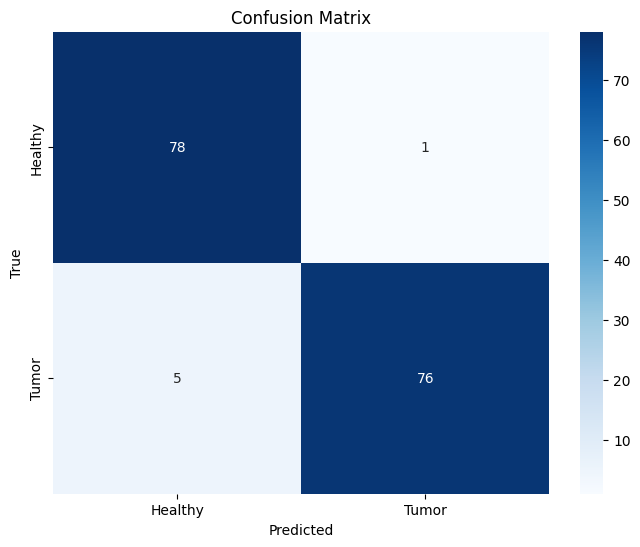

In [179]:
# Evaluate the model
evaluation_results = evaluate_model(model, test_loader)

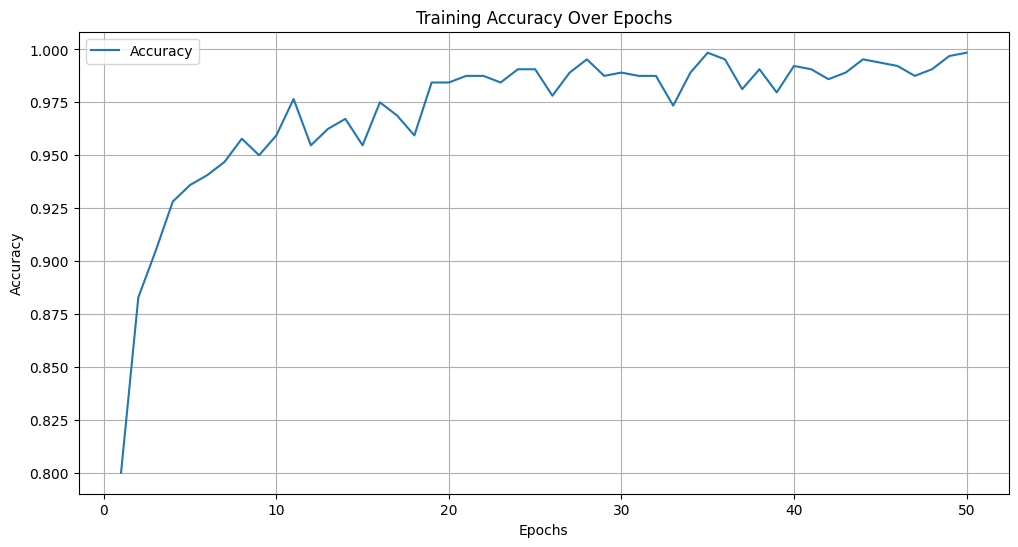

C:\Users\vulpe\AppData\Local\Temp\ipykernel_20960\4135774315.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metric_values, palette='viridis')


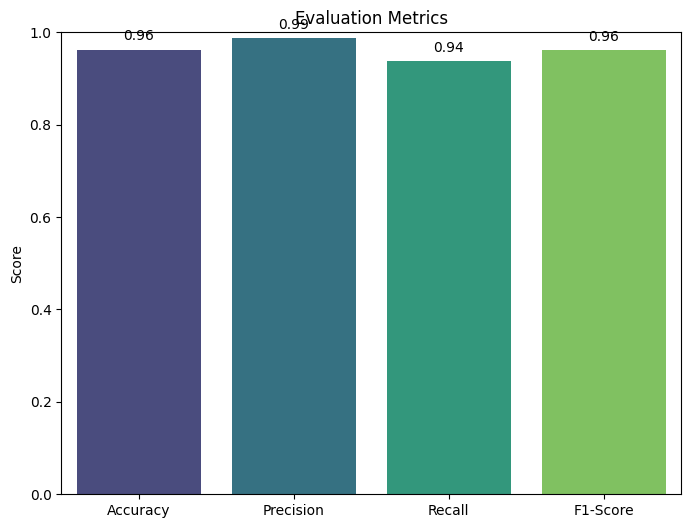

In [180]:
# Collect evaluation metrics for graph plotting
acc, precision, recall, f1, _ = evaluation_results

# Plot training accuracy
plot_metrics([train_accuracies], ['Accuracy'])

# Plot bar diagram for evaluation metrics
plot_bar_metrics(acc, precision, recall, f1)

### Testing our Model with new Data

In [229]:
import cv2
from PIL import Image
import torch
import torch.nn.functional as F  # For Softmax
from torchvision import transforms

# Transformation used during training
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Resize to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize as in training
])

# Function to load and preprocess a new image
def preprocess_new_image(image_path):
    # Load image (cv2 loads in BGR format, so convert to RGB)
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image could not be loaded: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Apply transformations
    img_transformed = transform(img)  # Apply ToTensor and Normalize

    # Add batch dimension (required by the model)
    img_transformed = img_transformed.unsqueeze(0)  # [C, H, W] -> [1, C, H, W]

    return img_transformed

# Function to predict the class with confidence
def predict_with_probability(model, image_tensor):
    class_labels = ["Healthy", "Tumor"]  # Define class labels
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get model predictions
        outputs = model(image_tensor.to(device))  # Logits
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()  # Class with highest probability
        confidence = probabilities[0, predicted_class].item()  # Confidence for the predicted class

    predicted_label = class_labels[predicted_class]  # Map class index to label
    return predicted_label, confidence

# Path to the new image
new_image_path = "data/new/image.jpg"  # Correctly set path
processed_image = preprocess_new_image(new_image_path)

# Load the trained model (ensure it is properly defined and loaded)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = torch.load("path_to_your_model.pth", map_location=device)  # Load your trained model
# model.to(device)

# Send the image to the model and get predictions with confidence
predicted_label, confidence = predict_with_probability(model, processed_image)

print(f"Predicted Class: {predicted_label}, Confidence: {confidence:.2f}")


Predicted Class: Tumor, Confidence: 1.00
